In [42]:
%load_ext autoreload
%autoreload 2

##  we're using the following packages (see requirements.txt for more):

#   msapy == 0.1.1
#   netneurotools (unclear version but the branch is merged on Oct 5, 2022)
#   numpy == 1.20.3
#   numba == 0.56.4
#   pandas == 1.3.5
#   bctpy == 0.6.0
#   networkx == 3.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import utils as ut
from copy import deepcopy
import pandas as pd
from numba import njit
import netneurotools.datasets

from netneurotools.metrics import communicability_wei, communicability_bin
from netneurotools.plotting import plot_fsaverage

from mayavi import mlab
mlab.init_notebook('png',1000,1000)

Notebook initialized with png backend.


In [43]:
SEED = 2023
pl.set_style(font_size=8)
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_reds = ['#FFFFFF', '#E84653', '#BF003F']
my_blues = ['#FFFFFF', '#3FA5C4', '#006685']
moreblue = sns.blend_palette(['#3FA5C4', '#006685'],as_cmap=True)
colormap = sns.blend_palette(my_colors,as_cmap=True)
redmap = sns.blend_palette(my_reds,as_cmap=True)
bluemap = sns.blend_palette(my_blues,as_cmap=True)

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

In [44]:
@njit
def simple_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = np.tanh(adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint])

    return X

@njit
def simple_linear_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]

    return X

def find_density(connectivity):
    return np.where(connectivity!=0,1,0).sum()/connectivity.shape[0]**2

def normer(x):
    return (x - x.min()) / (x.max() - x.min())

def spectral_normalization(target_radius,connectivity):
    return connectivity * target_radius/(np.max(np.abs(np.linalg.eigvals(connectivity))))

def threshold(lower_threshold,connectivity):
    connectivity = pd.DataFrame(connectivity)
    connectivity = connectivity.fillna(0)
    lower = np.percentile(connectivity, lower_threshold)
    upper = np.percentile(connectivity, 100-lower_threshold)
    connectivity[(connectivity < upper) & (connectivity > lower)] = 0.
    return connectivity

def event_maker(n_units, timesteps,probability=1):
    if probability < 1:
        input = rng.choice([0,1],p=[1-probability,probability],size=(n_units,timesteps))
        input = input.astype(float)
    else:
        input = np.zeros((n_units,timesteps))
        for node in range(n_units):
            event_timepoints = rng.integers(0,timesteps,1)
            input[node,event_timepoints] += 1
    
    return input

def brain_plotter(data,coordinates,axis,view=(90,180),size=20,cmap='viridis',scatter_kwargs=None):

    axis.scatter(coordinates[:,0],coordinates[:,1],coordinates[:,2],c=data,cmap=cmap,s=size,**scatter_kwargs)
    axis.view_init(*view)
    axis.axis('off')
    scaling = np.array([axis.get_xlim(),
                    axis.get_ylim(),
                    axis.get_zlim()])
    axis.set_box_aspect(tuple(scaling[:, 1]/2 - scaling[:, 0]))
    return axis

def make_influence_ratio(difference_matrix,axis=0):
    positives=(difference_matrix>0).sum(axis)/len(difference_matrix)
    negatives=(difference_matrix<0).sum(axis)/len(difference_matrix)
    return(positives-negatives)

In [45]:
def lesion_simple_nodes(complements, network, index,input,model = simple_linear_dynamical_system, model_kwargs = None):

    lesioned_network = deepcopy(network)
    for target in complements:
        lesioned_network[:,target] = 0.0
        lesioned_network[target,:] = 0.0
    model_kwargs = model_kwargs if model_kwargs else {}
    
    dynamics = model(lesioned_network,input,**model_kwargs)
    lesioned_signal = dynamics[index]
    return lesioned_signal

In [46]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = event_maker(6,timesteps)
#example_input = rng.normal(0,1,(6,timesteps))

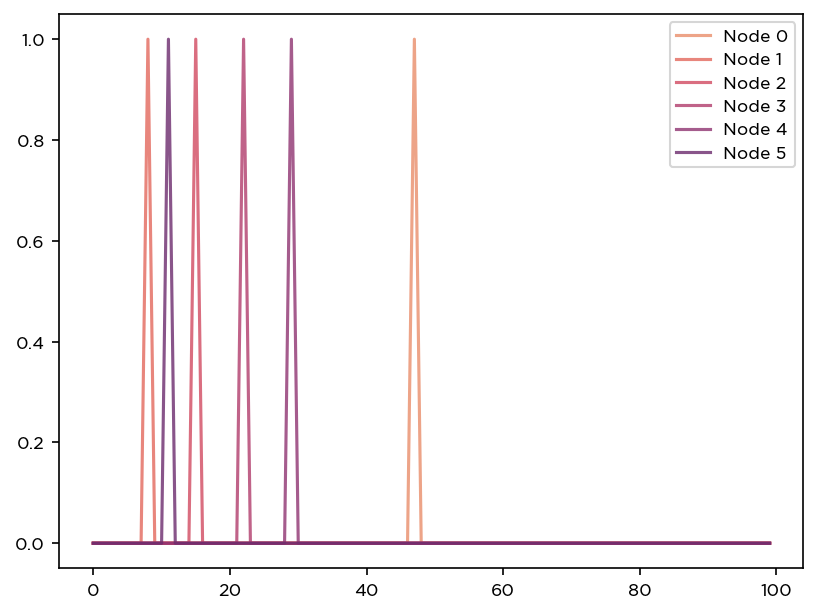

In [47]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [48]:
simple_chain_dynamics = simple_linear_dynamical_system(chain,example_input)
closed_chain_dynamics = simple_linear_dynamical_system(closedchain,example_input)
symmetric_chain_dynamics = simple_linear_dynamical_system(symmetricchain,example_input)

/tmp/ipykernel_2918/2929560332.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]
/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_2918/2929560332.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]
/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(Numb

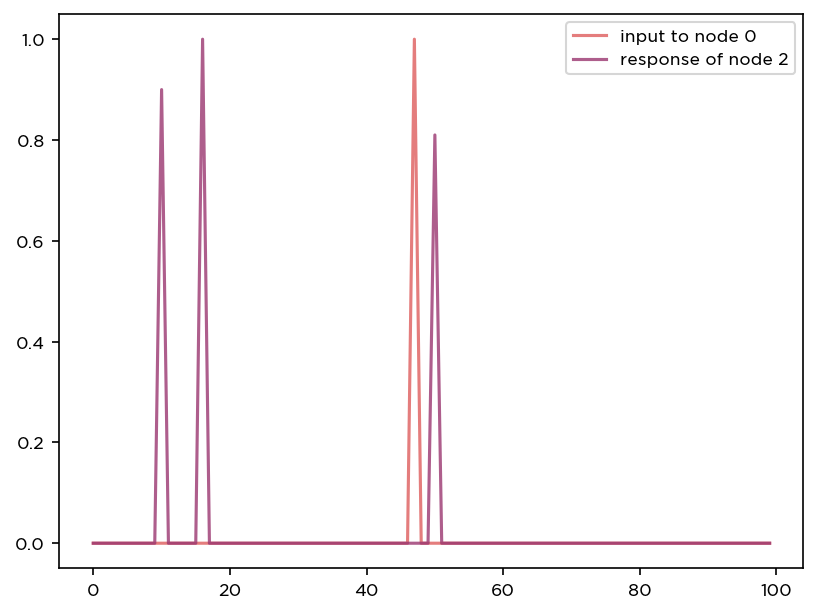

In [49]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=2):
    plt.plot(example_input[0],alpha=0.8)
    plt.plot(simple_chain_dynamics[2],alpha=0.8)

plt.legend(['input to node 0','response of node 2']);


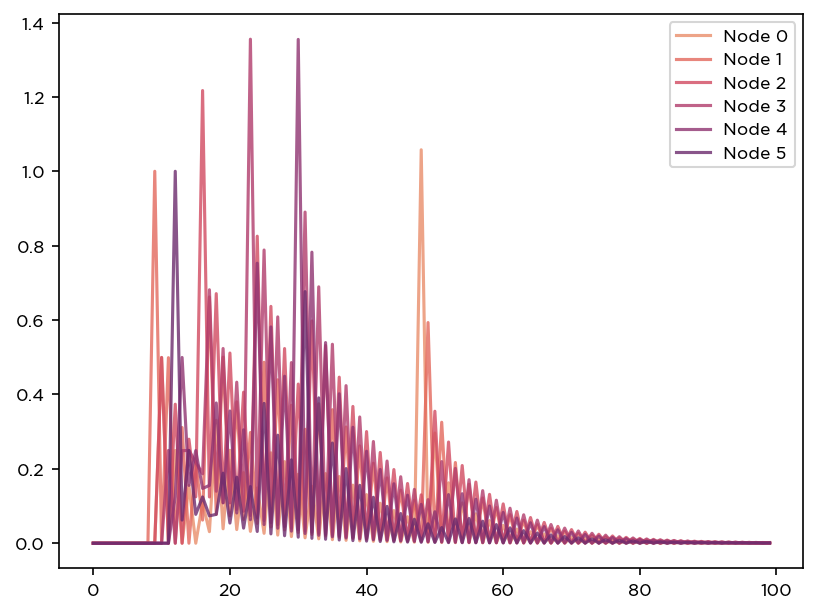

In [50]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'])

In [51]:
cchain= communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain= communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain= communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [52]:
lesion_params = {'network': chain, 'input': example_input}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22919.69it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 16652.32it/s]
2it [00:00, 16.09it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 16664.73it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 16470.45it/s]
4it [00:00, 15.21it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23109.11it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22900.14it/s]
6it [00:00, 14.88it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 19127.51it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23588.35it/s]
2it [00:00, 15.82it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24786.28it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 7230.78it/s]
4it [00:00, 14.30it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 17000.35it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 19608.14it/s]
6it [00:00, 14.98it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24044.74it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23920.46it/s]
2it [00:00, 16.51it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 20177.05it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23188.96it/s]
4it [00:00, 16.48it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 24174.66it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 6221.27it/s]
6it [00:00, 15.47it/s]


In [53]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

In [54]:
chain_mask = np.where(cchain!=0,1,0)
closedchain_mask = np.where(ccchain!=0,1,0)
symmetricchain_mask = np.where(csychain!=0,1,0)

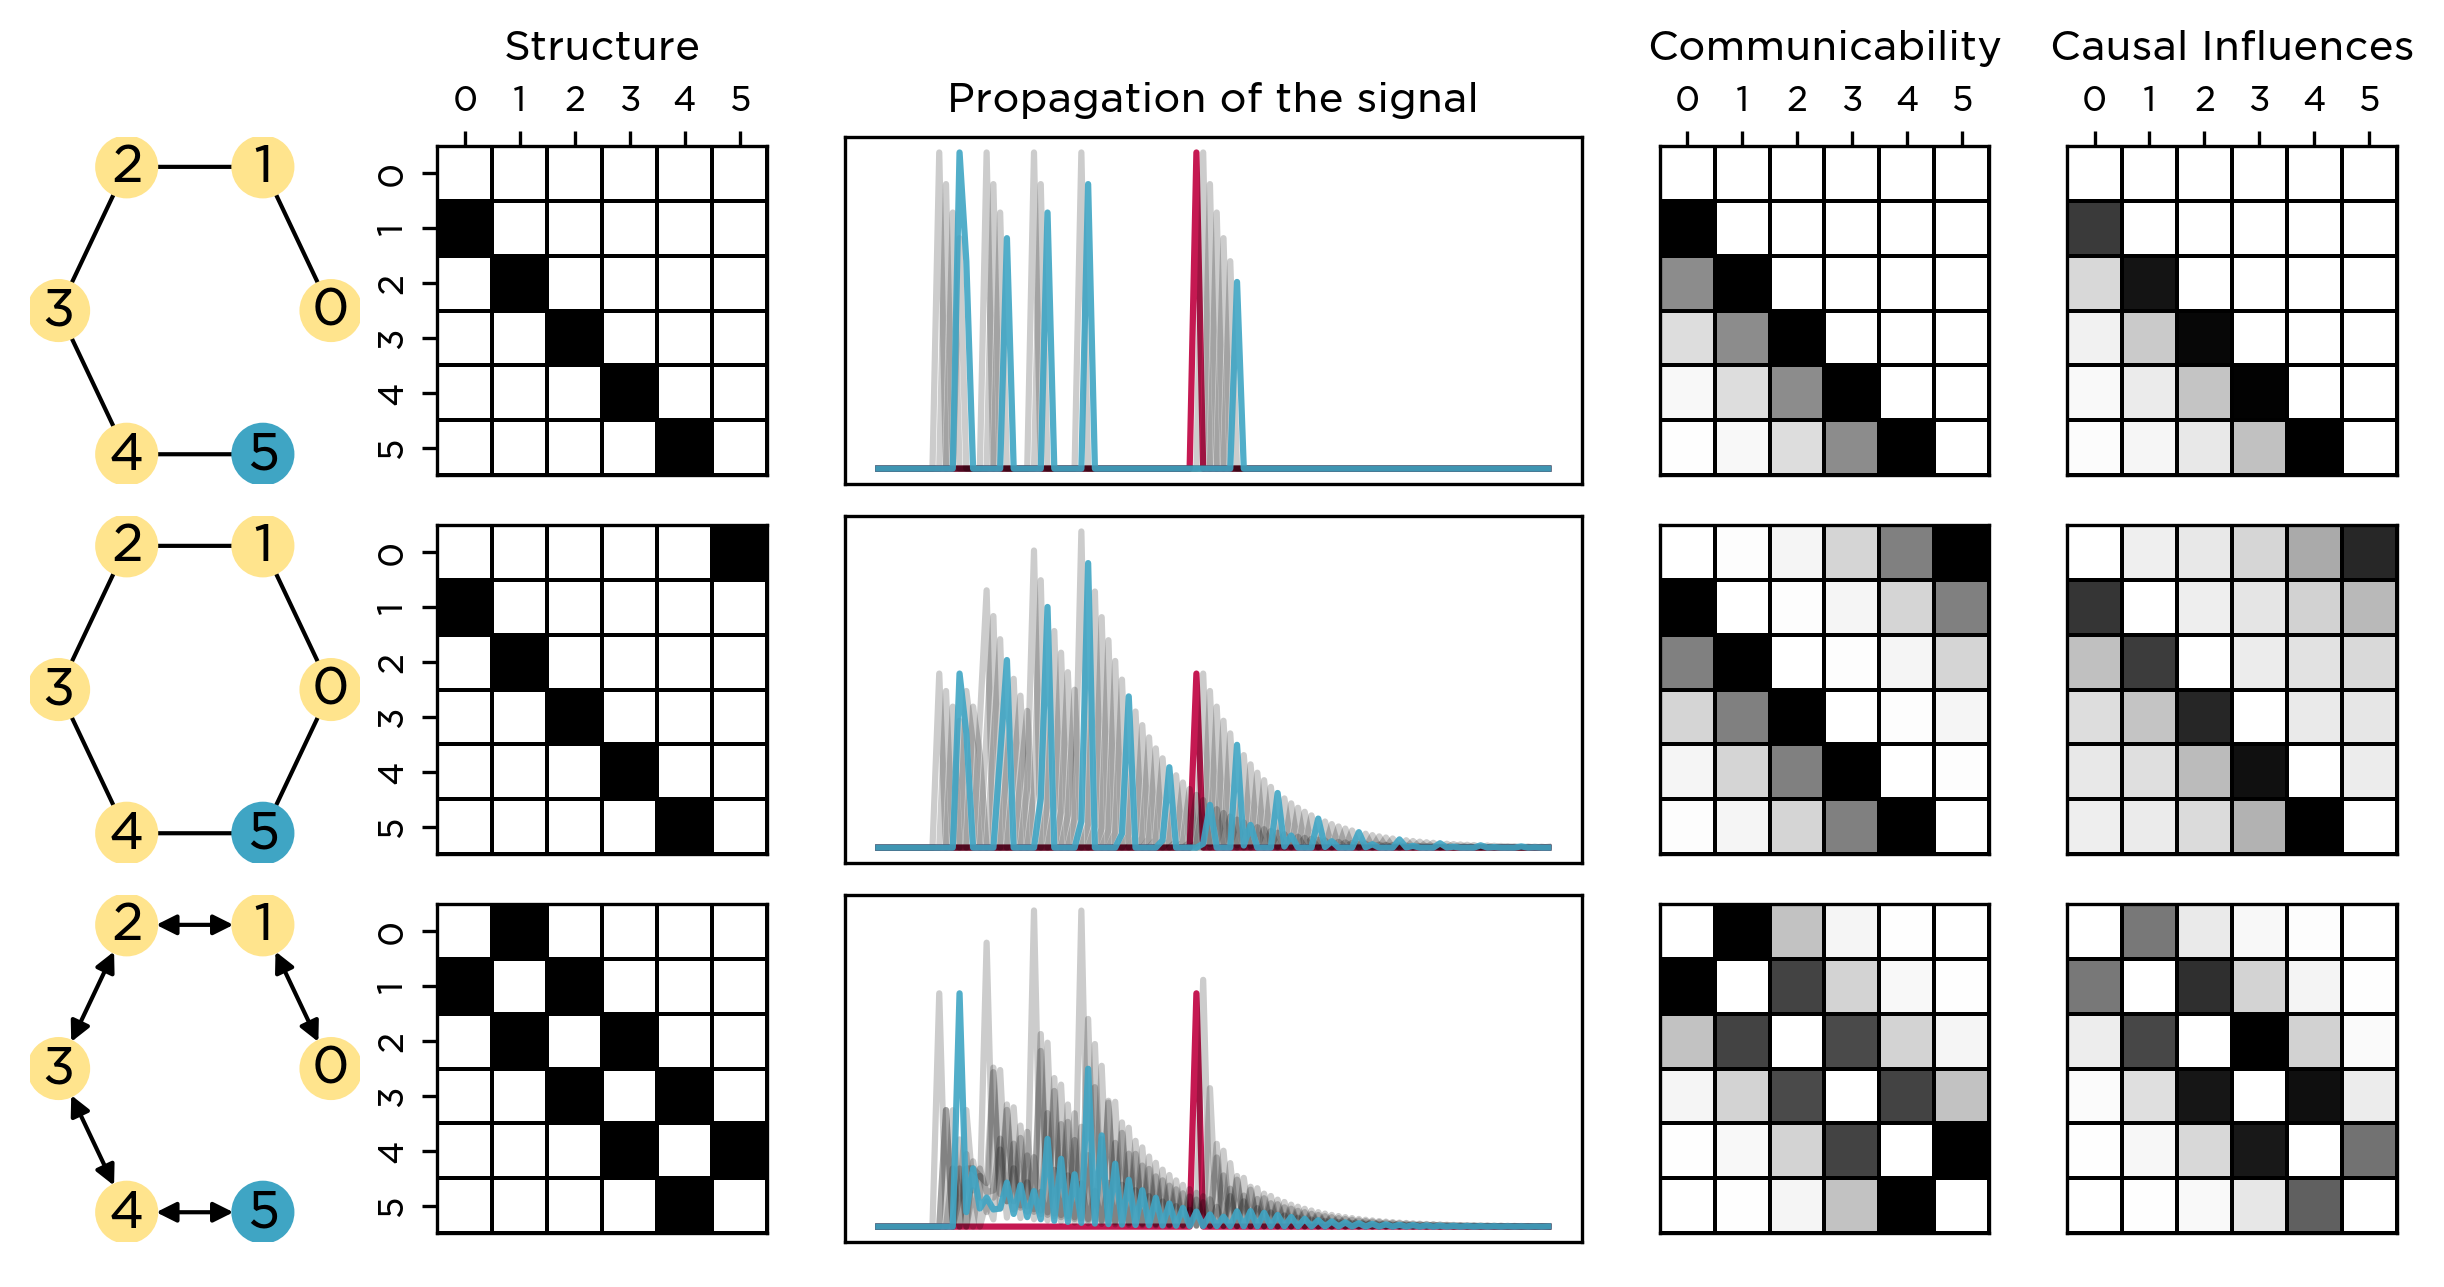

In [55]:
# fig,axes = plt.subplot_mosaic([['X','CX','CIX','B', 'B','A'],
#                                ['Y','CY','CIY','D', 'D','C'],
#                                ['Z','CZ','CIZ','F', 'F','E']],figsize=(8,4.2),dpi=300)

fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(8,4.2),dpi=300)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain*chain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain*closedchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain*symmetricchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=['#FFE48D','#FFE48D','#FFE48D','#FFE48D','#FFE48D','#3FA5C4']
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:
    axes[ax].plot(example_input[0],c=my_colors[-1],alpha=0.9)

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

axes['B'].title.set_text('Propagation of the signal')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.5)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [56]:
netneurotools.datasets.available_connectomes()

['celegans',
 'drosophila',
 'human_func_scale033',
 'human_func_scale060',
 'human_func_scale125',
 'human_func_scale250',
 'human_func_scale500',
 'human_struct_scale033',
 'human_struct_scale060',
 'human_struct_scale125',
 'human_struct_scale250',
 'human_struct_scale500',
 'macaque_markov',
 'macaque_modha',
 'mouse',
 'rat']

In [100]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale060')

In [101]:
connectivity = spectral_normalization(0.9,human['conn'])
n_neurons = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)
chuman = normer(communicability_wei(connectivity))


In [102]:
rng = np.random.default_rng(seed=SEED)
timesteps = 100
noise_strength = 0.5

noise = rng.normal(0,noise_strength,(n_neurons,timesteps))

#input = event_maker(len(connectivity),timesteps)
input = noise
simple_human_dynamics = simple_linear_dynamical_system(connectivity,input)

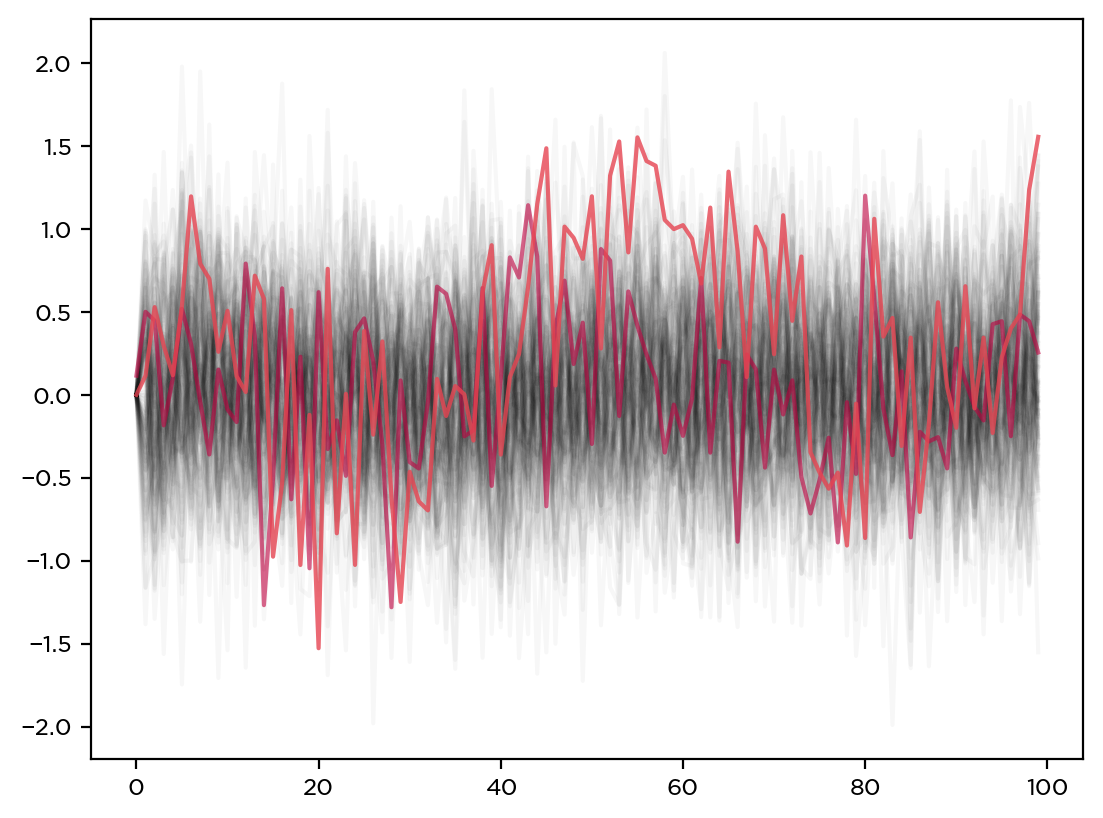

In [103]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics.T,alpha=0.03,color='k')
plt.plot(input[-1],alpha=0.6,color=my_colors[-1])

plt.plot(simple_human_dynamics[-1],alpha=0.8,color=my_colors[-2]);



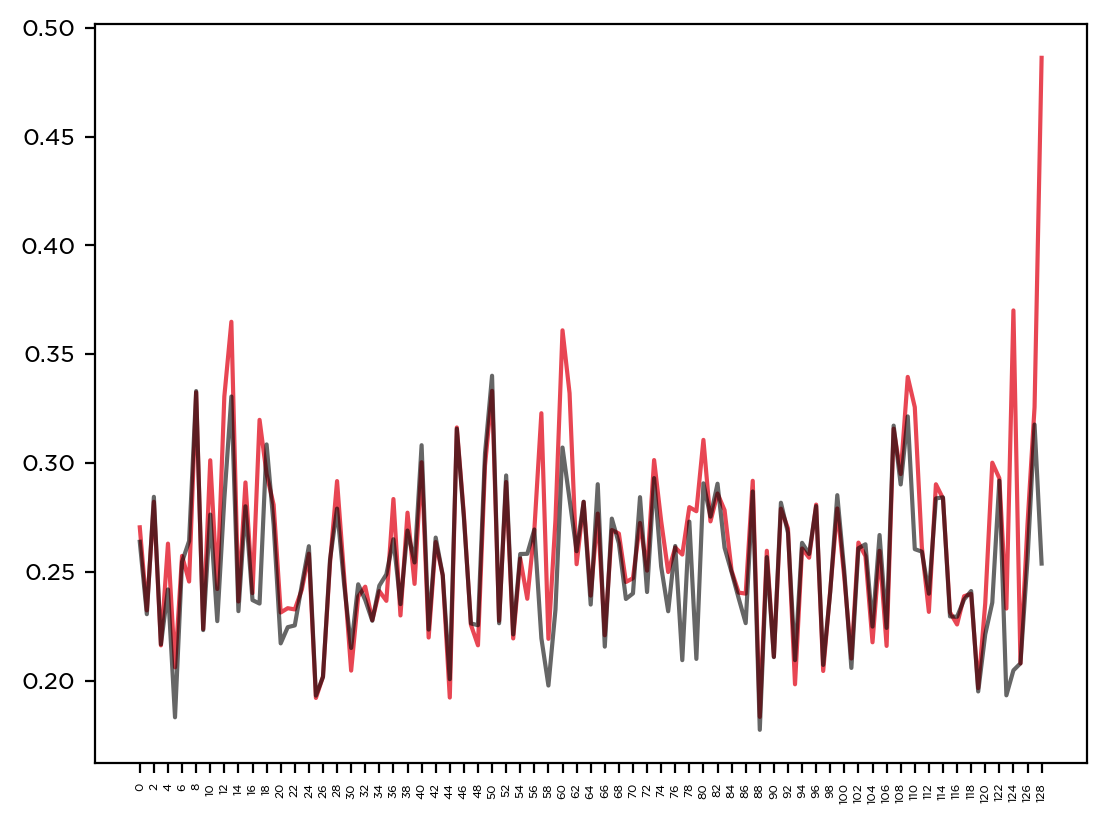

In [104]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics.var(axis=1),color = my_colors[-2])
plt.plot(input.var(axis=1),alpha=0.6,color='k');
plt.xticks(np.arange(0,len(connectivity),2),rotation=90,fontsize=4);

/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

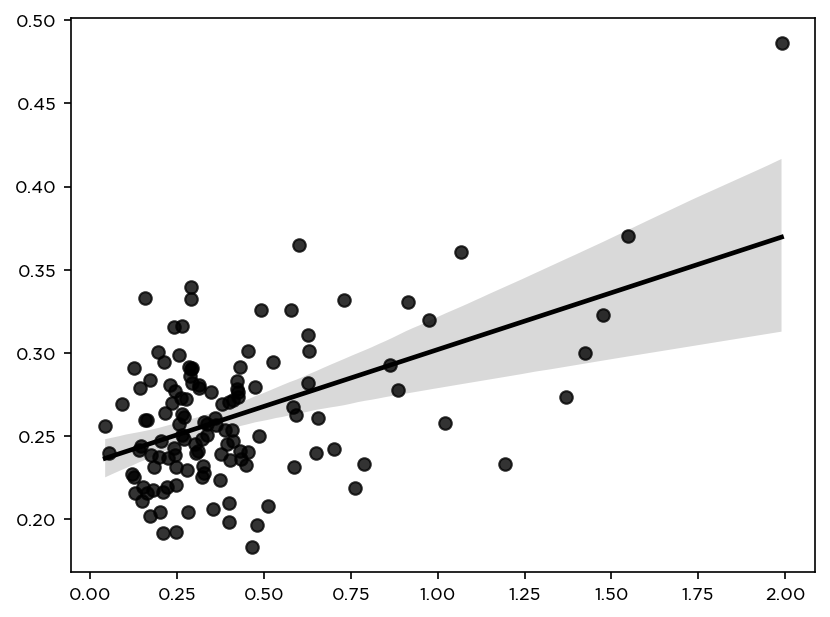

In [105]:
plt.figure(dpi=150)
sns.regplot(connectivity.sum(axis=1),simple_human_dynamics.var(axis=1),color='k')


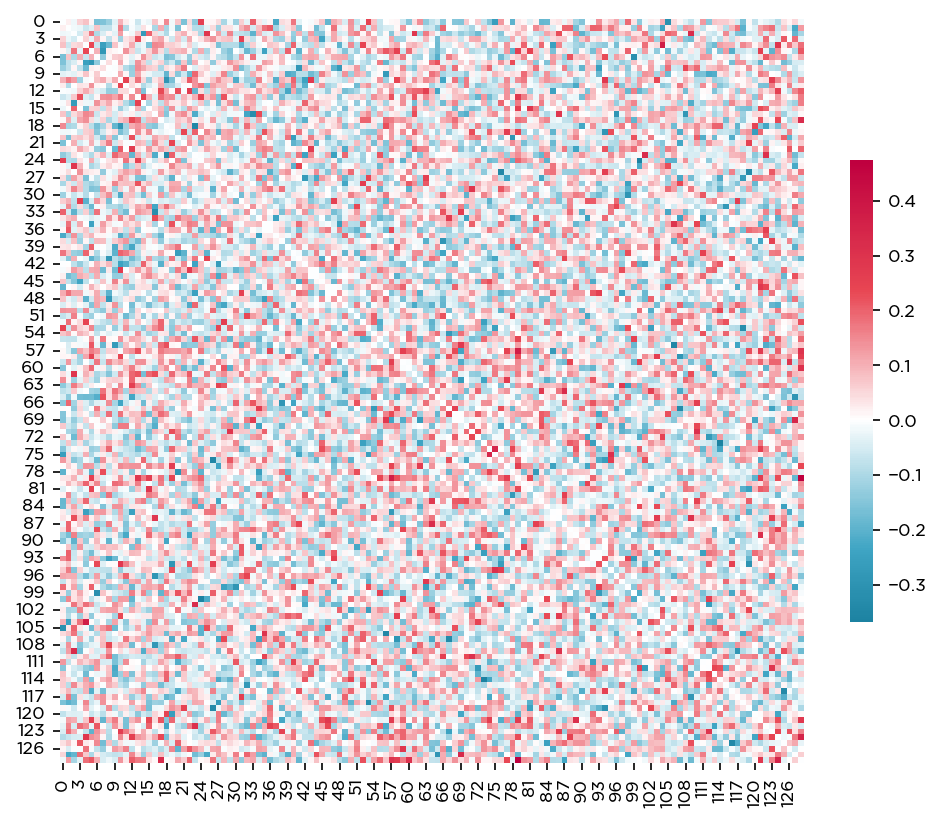

In [106]:
plt.figure(figsize=(8,8),dpi=150)
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0.)
sns.heatmap(fc,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [ ]:
lesion_params = {'network': connectivity, 'input': input}
ci_mat = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1,parallelize_over_games=True)
# takes around 190 minutes for human_struct_scale125
# takes around 30 minutes for human_struct_scale060
# takes around 10 minutes for human_struct_scale033

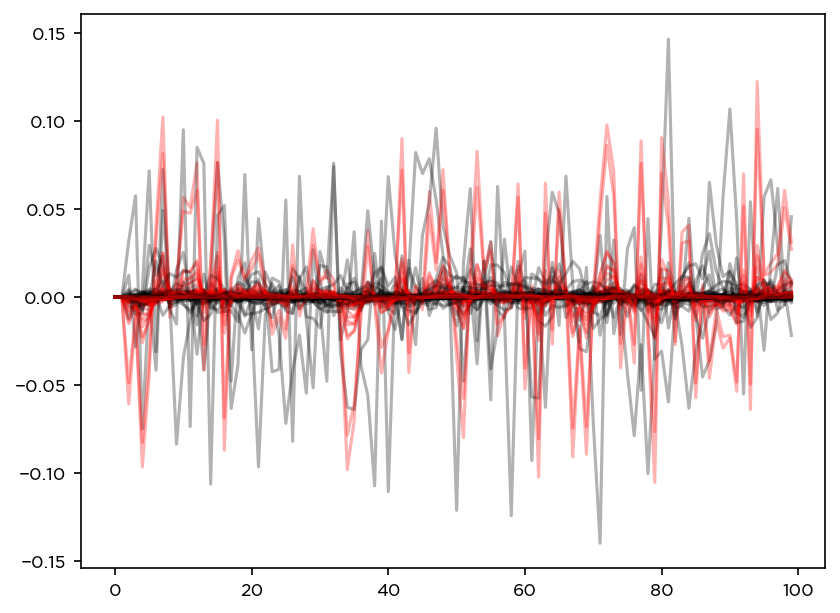

In [108]:
plt.figure(dpi=150)
for i in range(n_neurons):
    plt.plot(ci_mat[i][1],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat[1][i],'r',alpha=0.3) # influenced by the node

In [109]:
ci_mate = ci_mat.groupby(level=0).var().fillna(0)

In [131]:
normalized_ci = normer(ci_mate*communication_mask)
diff = normalized_ci - chuman
diff = threshold(1,diff)
boths_outgoing = make_influence_ratio(diff)
boths_incoming = make_influence_ratio(diff,axis=1)


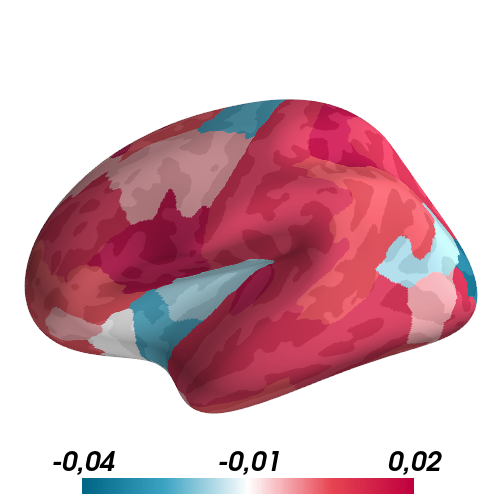


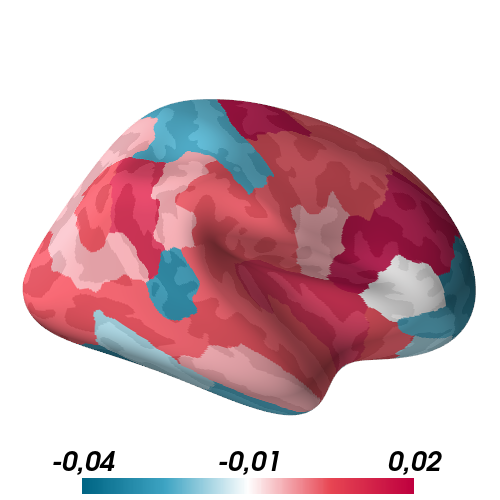


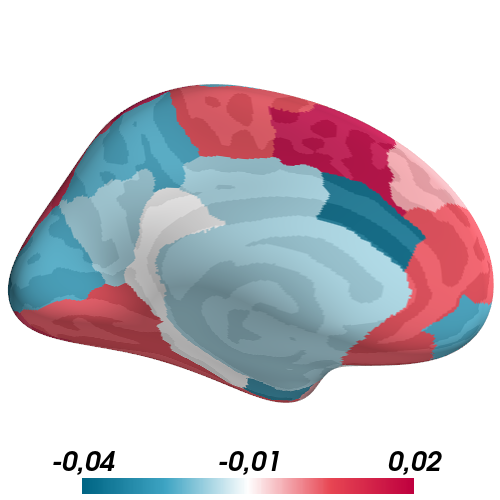


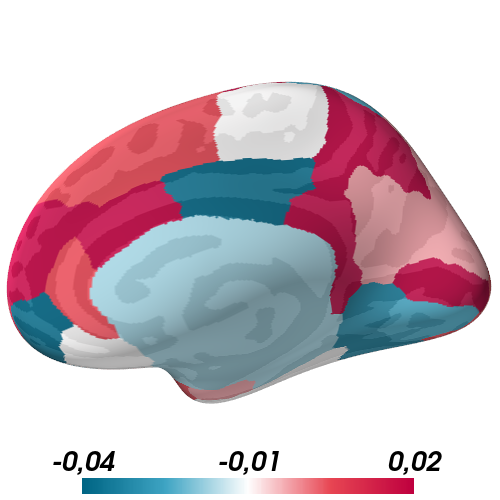

In [132]:
lhannot = '/home/kayson/ownCloud/communication-and-causation/annot/lh.lausanne2018.scale2.annot'
rhannot = '/home/kayson/ownCloud/communication-and-causation/annot/rh.lausanne2018.scale2.annot'

plot_fsaverage(boths_outgoing,lhannot=lhannot,rhannot=rhannot,order='lr',**{'colormap':colormap,'surf':'inflated','views':['lat','med']})


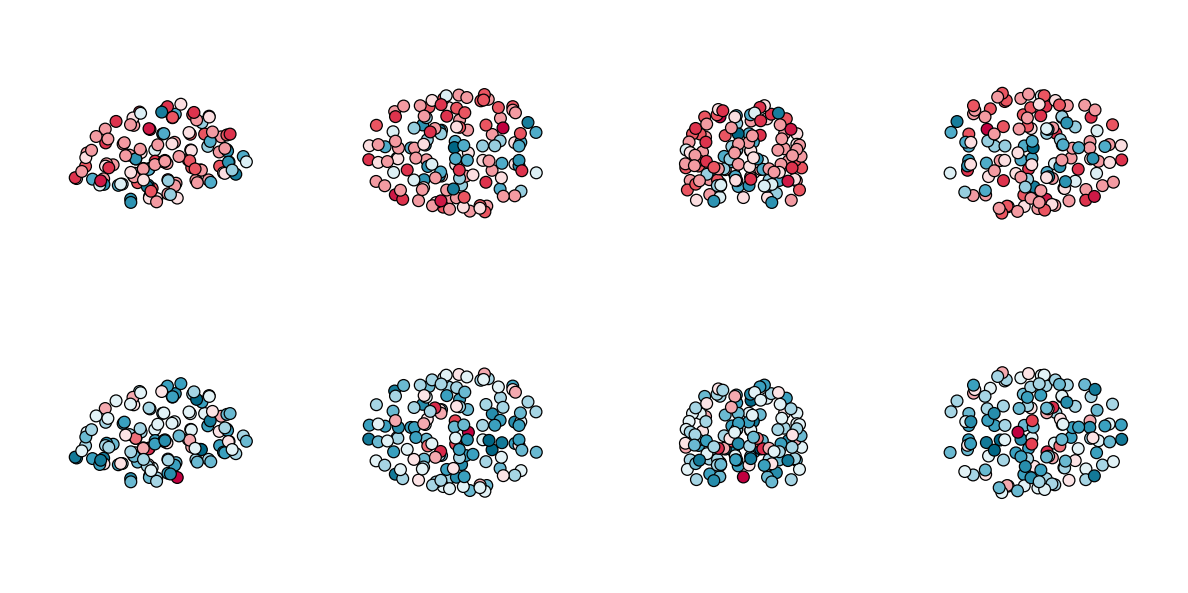

In [133]:
scatter_kw = dict(alpha=1,linewidth=0.3, edgecolor='k')
size=8
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H']],figsize=(4,2),subplot_kw=dict(projection='3d'),dpi=300)
brain_plotter(boths_outgoing,human['coords'],axes['A'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['B'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['C'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['D'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)

brain_plotter(boths_incoming,human['coords'],axes['E'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['F'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['G'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['H'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=1)

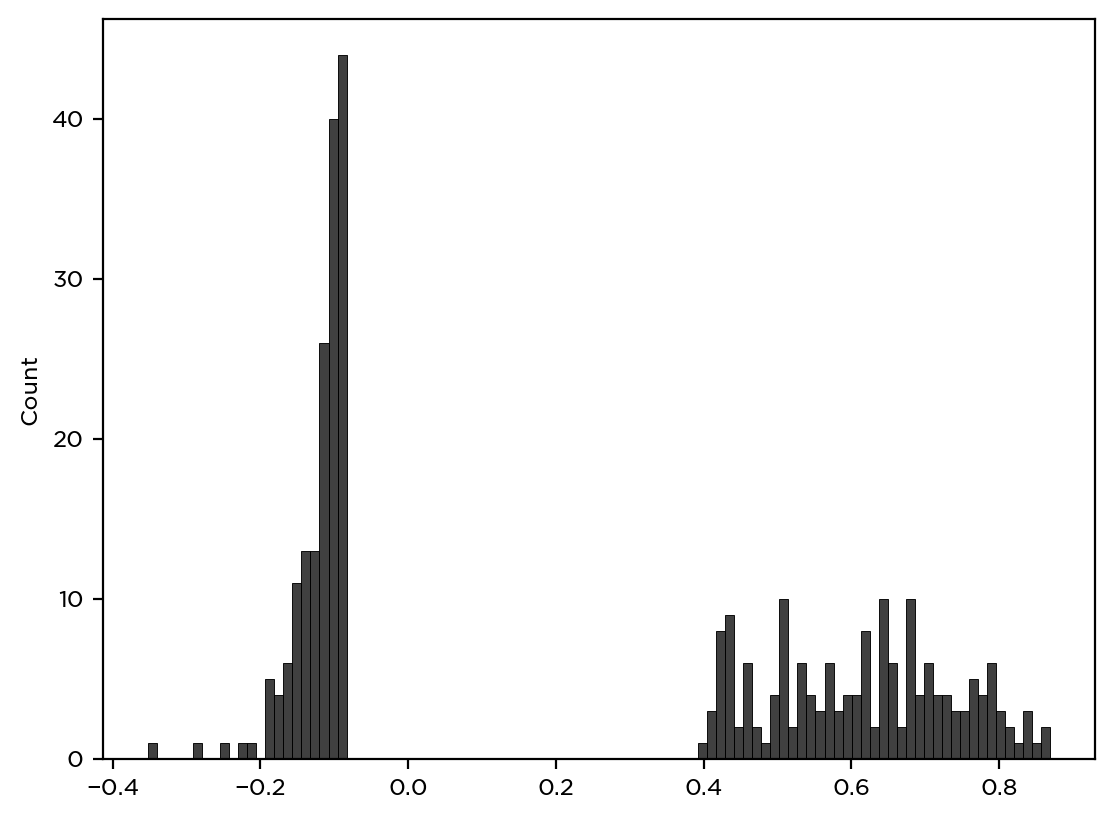

In [118]:
plt.figure(dpi=200)
sns.histplot(diff.values.flatten()[diff.values.flatten()!=0.],bins=100,color='k');
#

In [134]:
log_ci = np.abs(np.nan_to_num(np.log(normalized_ci),neginf=0))
log_comm = np.abs(np.nan_to_num(np.log(chuman),neginf=0))
log_sc = np.abs(np.nan_to_num(np.log(normer(connectivity)),neginf=0))

/tmp/ipykernel_2918/227954366.py:2: RuntimeWarning: divide by zero encountered in log
  log_comm = np.abs(np.nan_to_num(np.log(chuman),neginf=0))
/tmp/ipykernel_2918/227954366.py:3: RuntimeWarning: divide by zero encountered in log
  log_sc = np.abs(np.nan_to_num(np.log(normer(connectivity)),neginf=0))


/tmp/ipykernel_2918/2262069988.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


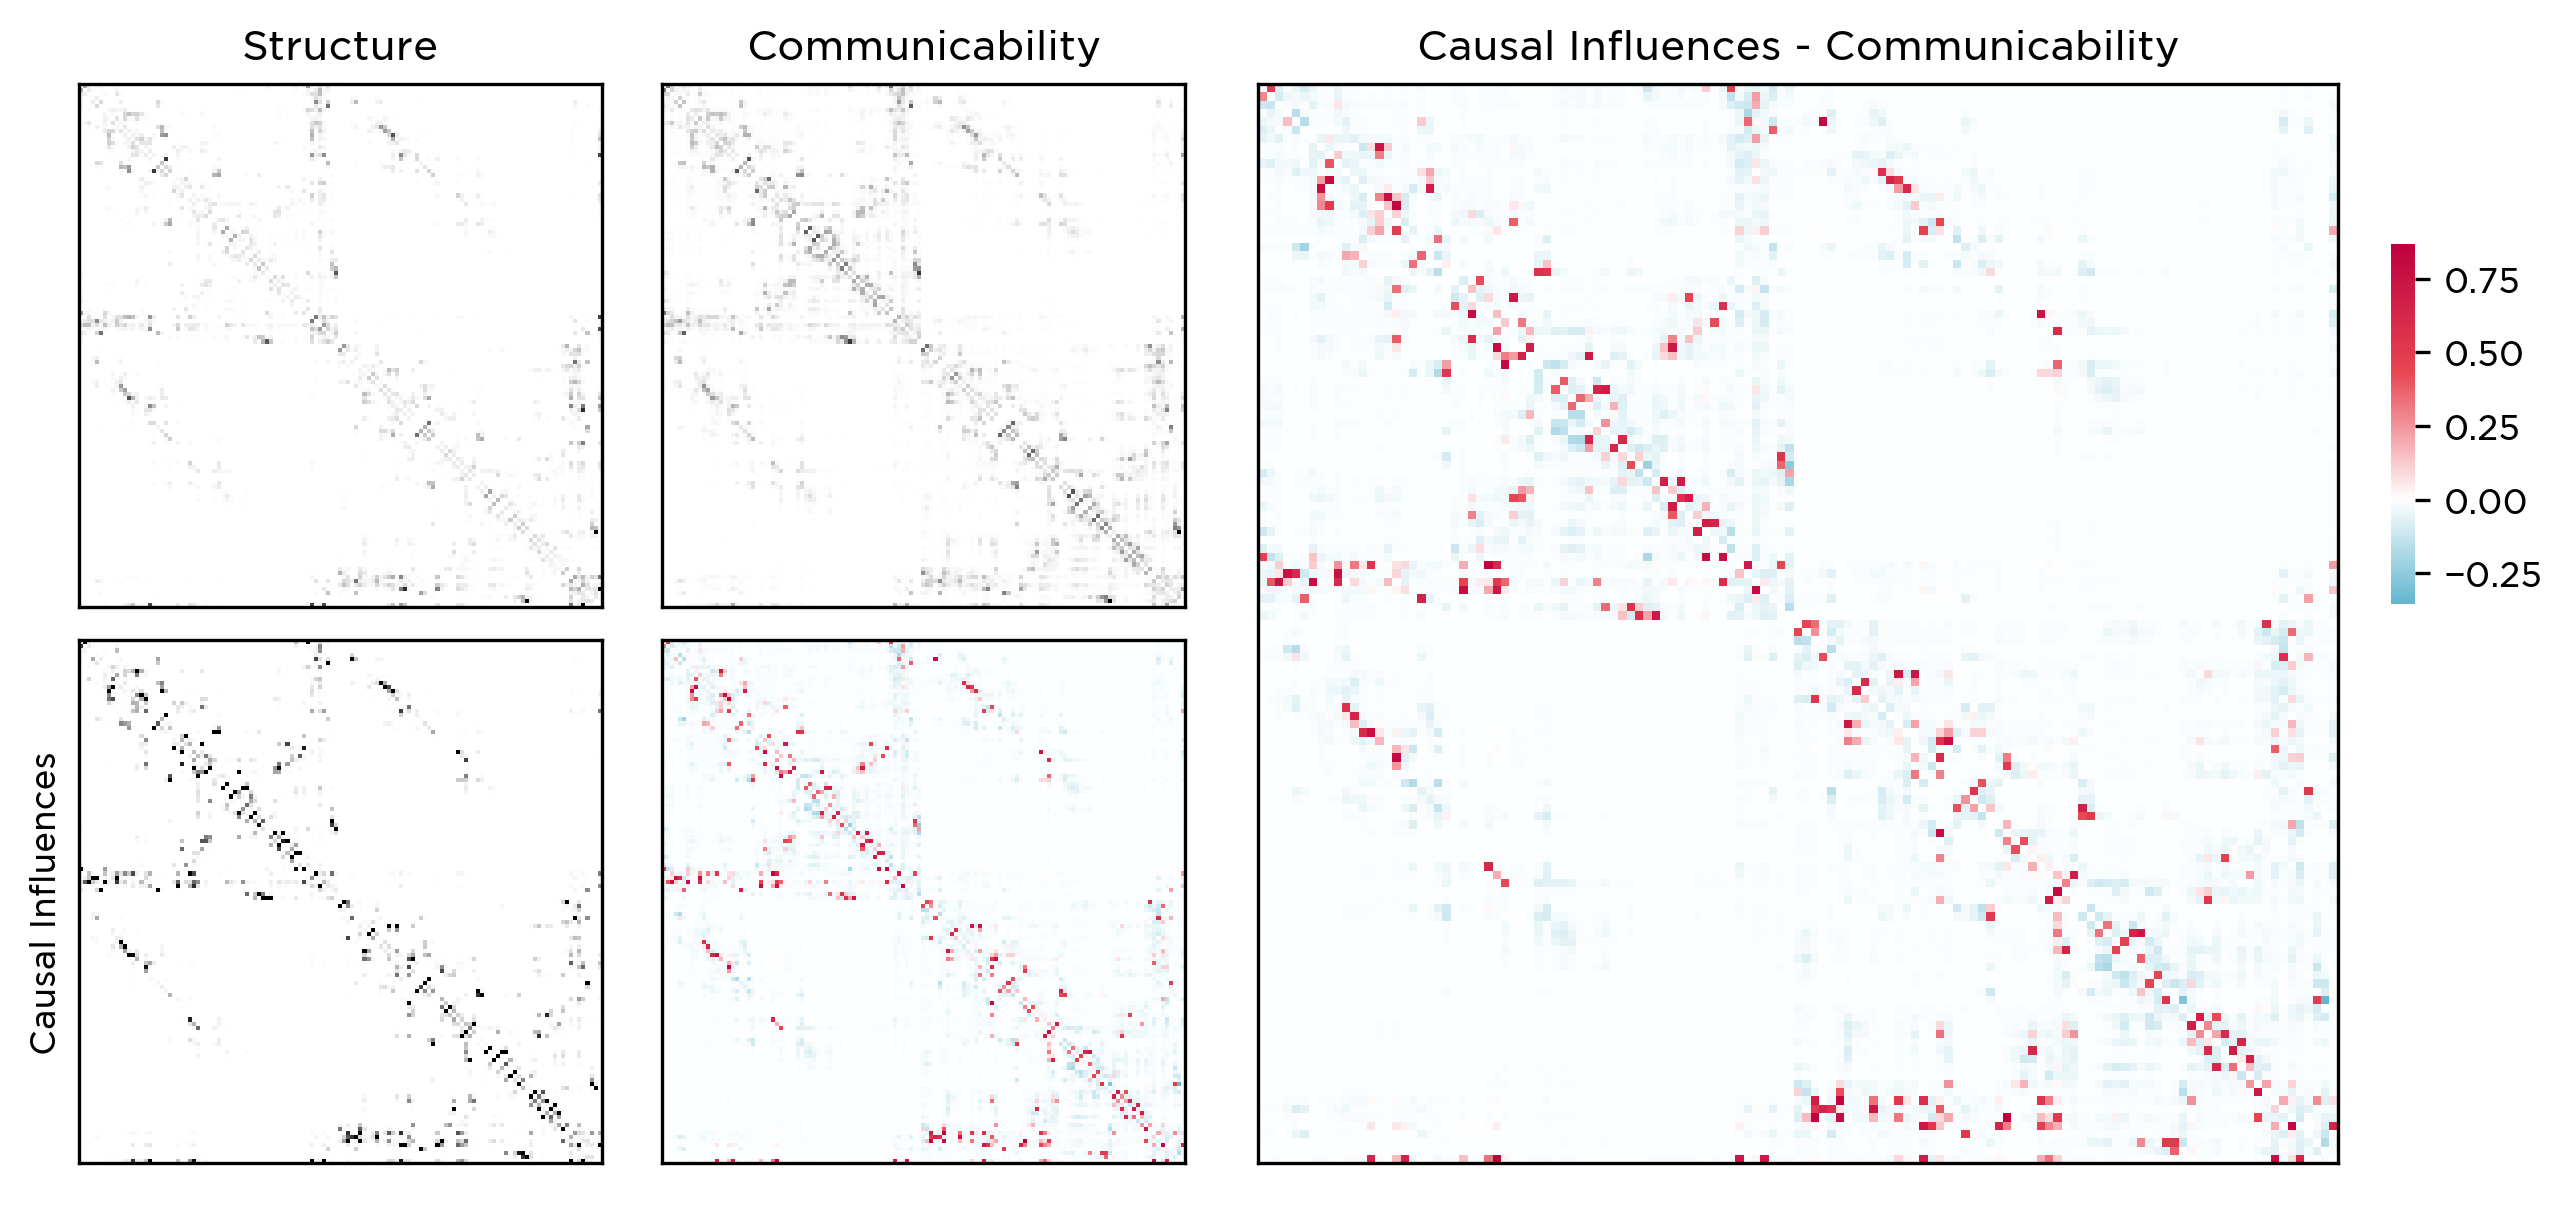

In [135]:
fig,axes = plt.subplot_mosaic([['A','CA','Z','Z'],
                               ['CI','DI','Z','Z']],figsize=(8,4),dpi=300)
cbar_ax = fig.add_axes([1, .5, .01, .3])

sns.heatmap(normer(connectivity),square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(chuman,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(normalized_ci*communication_mask,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar_ax=cbar_ax,ax=axes['Z'],linewidths=0.0)
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

#axes['B'].title.set_text('Propagation of the signal through the human connectome')
axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['Z'].title.set_text('Causal Influences - Communicability')
axes['CI'].set_ylabel("Causal Influences")

fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

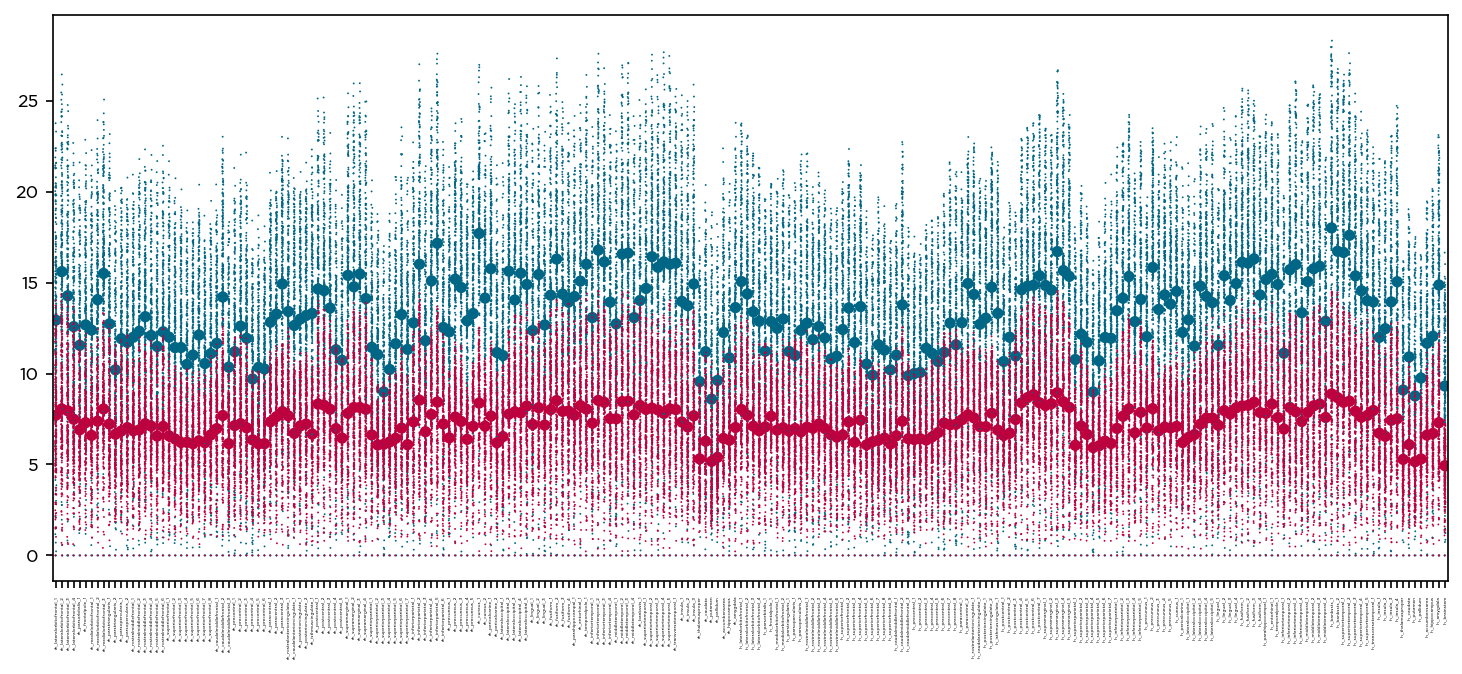

In [761]:
plt.figure(figsize=(12,5),dpi=150)
sns.pointplot(data=log_ci,color=my_colors[0],label='Causal Influence',join=False,markers='.',errwidth=0.8) #red
sns.pointplot(data=log_comm,color=my_colors[-1],label='Communicability',join=False,markers='.',errwidth=0.8)

sns.stripplot(data=log_ci,color=my_colors[0],label='Causal Influence',size=0.9) #red
sns.stripplot(data=log_comm,color=my_colors[-1],label='Communicability',size=0.9)
#plt.legend(frameon=False)
plt.xticks(ticks = [i for i,_ in enumerate(human.labels)],labels=human.labels,rotation=90,fontsize=2);

<AxesSubplot:>

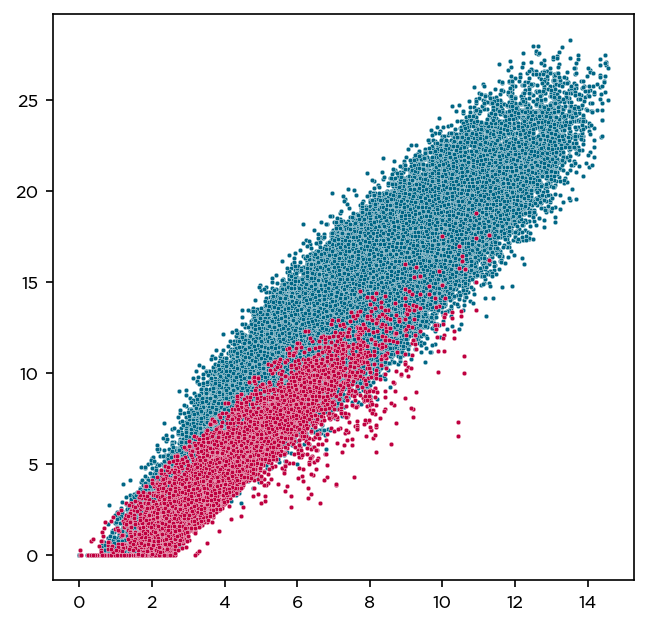

In [762]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_comm.flatten(),y=log_ci.flatten(),color=my_colors[0],s=5)
sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color=my_colors[-1],s=5)
#sns.lineplot(x=log_comm.flatten(), y=log_comm.flatten(), color='k', linestyle='--')


In [763]:
human.keys()

dict_keys(['conn', 'coords', 'dist', 'labels', 'ref'])

<AxesSubplot:>

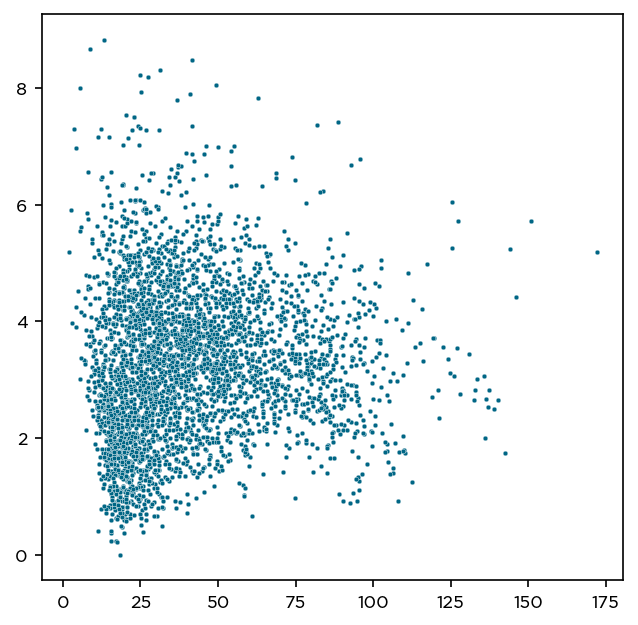

In [212]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=human['dist'].flatten()[human['dist'].flatten()!=0],y=log_comm.flatten()[human['dist'].flatten()!=0],color=my_colors[0],s=5)

In [335]:
input_events = event_maker(len(connectivity),timesteps,probability=1)
simple_human_dynamics_events = simple_linear_dynamical_system(connectivity,input_events)

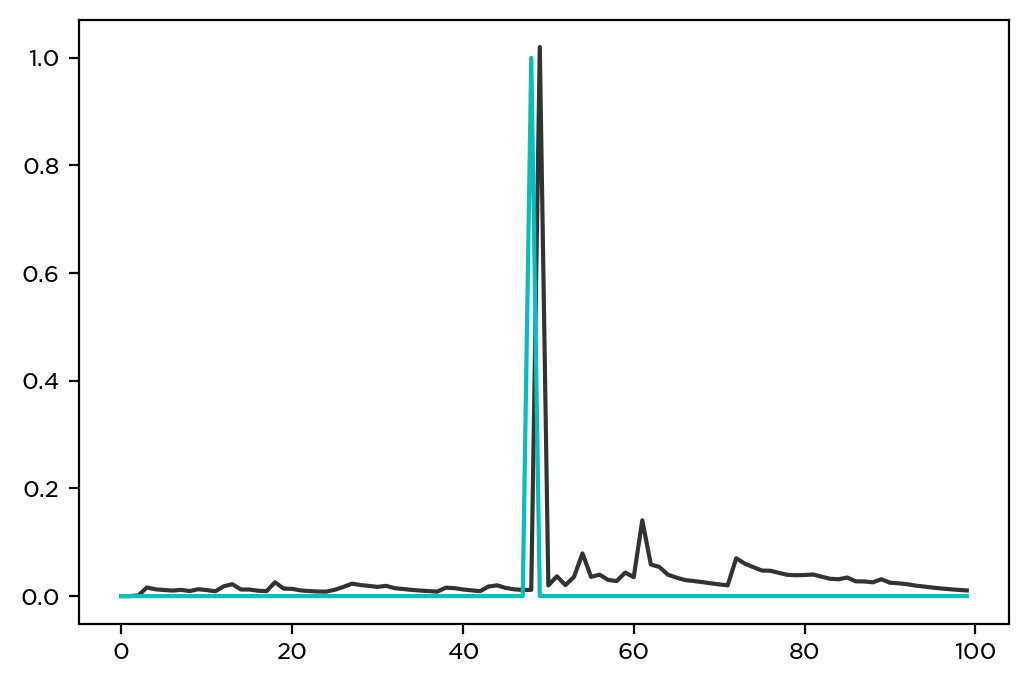

In [340]:
plt.figure(dpi=200)
plt.plot(simple_human_dynamics_events[4],alpha=0.8,color='k')
plt.plot(input_events[4],color='c');

In [ ]:
lesion_params = {'network': connectivity, 'input': input_events}
ci_mat_events = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1,parallelize_over_games=True)

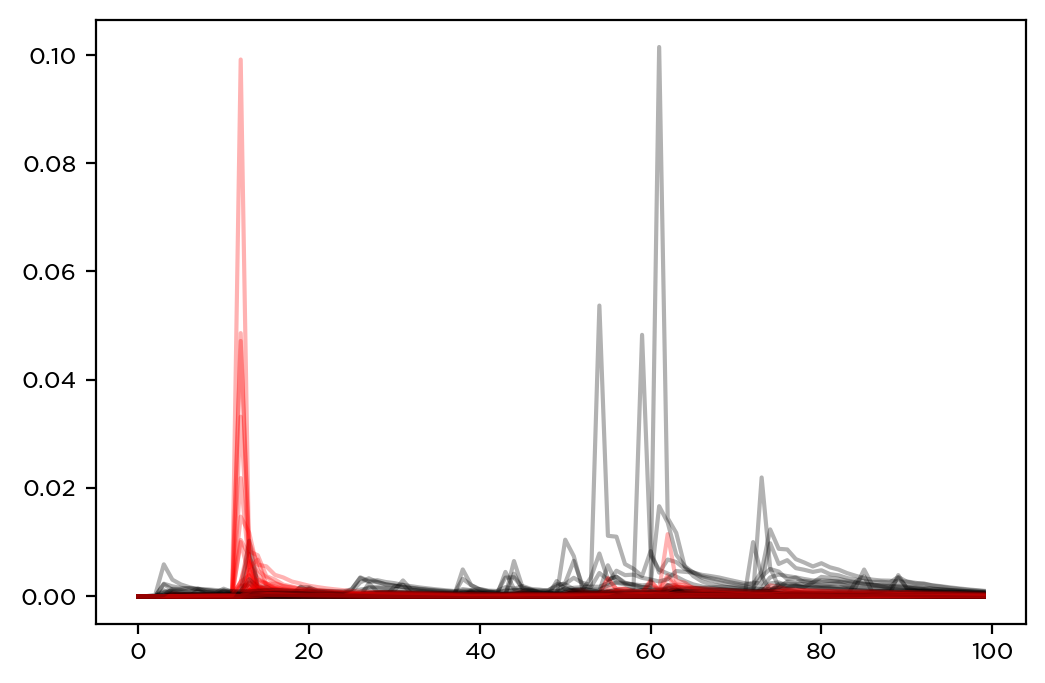

In [342]:
plt.figure(dpi=200)
for i in range(n_neurons):
    plt.plot(ci_mat_events[i][1],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat_events[1][i],'r',alpha=0.3) # influenced by the node

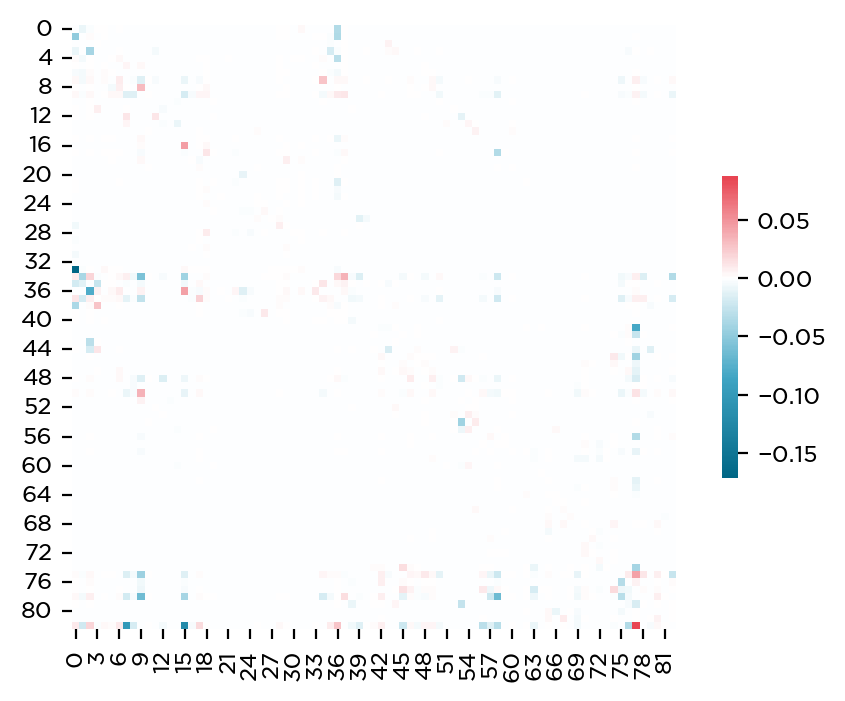

In [343]:
ci_mate_events = ci_mat_events.groupby(level=0).var().fillna(0)
plt.figure(dpi=200)
sns.heatmap(normer(ci_mate_events)-normalized_ci,center=0,square=True,cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [422]:
normalized_ci = normer(ci_mate_events*communication_mask)
diff = normalized_ci - chuman
diff = diff.fillna(0)
lower = np.percentile(diff, 5)
upper = np.percentile(diff, 95)
diff[(diff < upper) & (diff > lower)] = 0.0

log_ci = np.abs(np.nan_to_num(np.log(normalized_ci),neginf=0))


In [423]:
positives = diff[diff>0]
negatives = diff[diff<0]
positives.sum().sum()/negatives.sum().sum()

-2.8786190785985557

/tmp/ipykernel_11189/1895396242.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


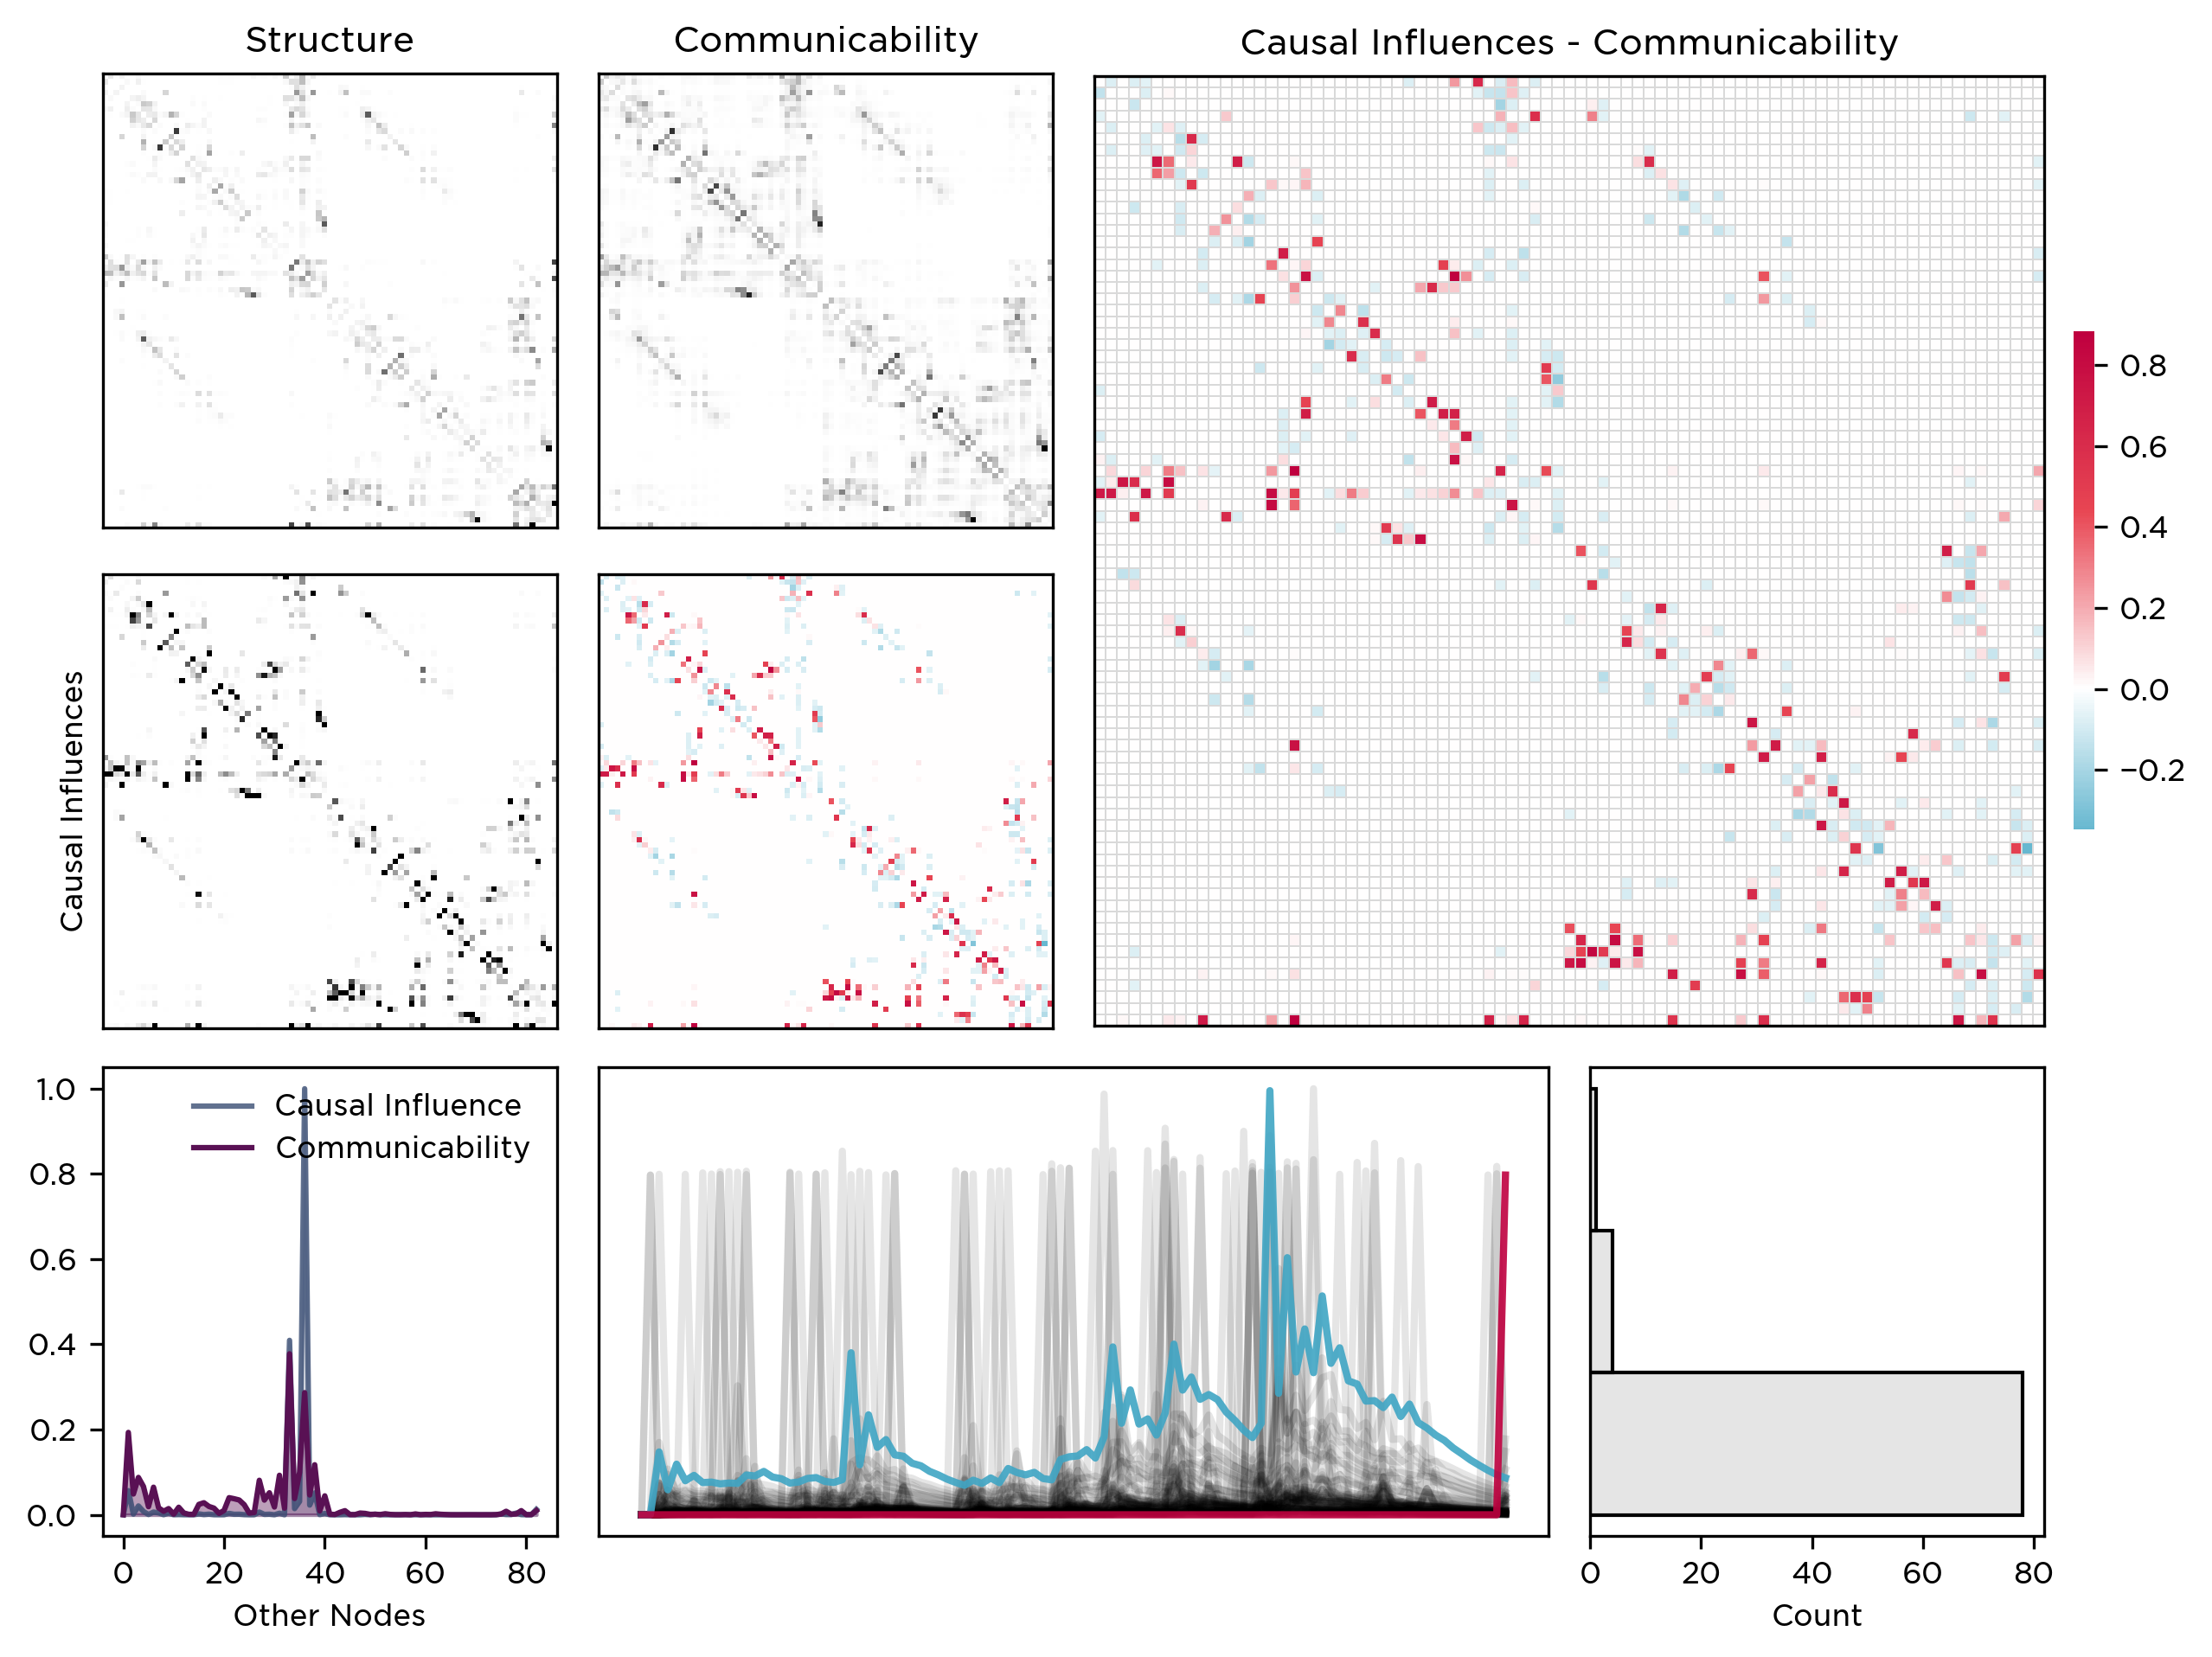

In [347]:
fig,axes = plt.subplot_mosaic([['A','CA','Z','Z'],
                               ['CI','DI','Z','Z'],
                                ['C','B','B','H']],figsize=(8,6.4),dpi=300)
cbar_ax = fig.add_axes([1, .5, .01, .3])

sns.heatmap(normer(connectivity),square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(chuman,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(normalized_ci,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap(diff,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')
sns.heatmap(diff,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar_ax=cbar_ax,ax=axes['Z'],linewidths=0.01, linecolor='#D9D9D9')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['B'].xaxis.set_visible(False)
for i in range(len(connectivity)):
    if i < len(connectivity)-1:
        axes['B'].plot(simple_human_dynamics_events.T[:,i],c='k',alpha=0.1,linewidth=2)
    else:
        axes['B'].plot(simple_human_dynamics_events.T[:,i],c=my_colors[1],alpha=(0.9),linewidth=2)
axes['B'].plot(input_events[0],c=my_colors[-1],alpha=0.9,linewidth=2)

sns.histplot(y=simple_human_dynamics_events.T[-1,:],ax=axes['H'],binwidth=0.1,fill=True,color='k',element="bars",alpha=0.1)
#sns.histplot(y=simple_human_dynamics.T[-1,:],ax=axes['H'],binwidth=0.1,fill=False,color='k',element="step")

axes['H'].yaxis.set_visible(False)
#axes['B'].title.set_text('Propagation of the signal through the human connectome')
axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['Z'].title.set_text('Causal Influences - Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['B'].yaxis.set_visible(False)


x = np.linspace(0, len(connectivity)-1, len(connectivity))

axes['C'].fill_between(x,normalized_ci[0].fillna(0),color='#394D73',alpha=0.2)
axes['C'].fill_between(x,chuman[:,0],color='#591154',alpha=0.4)
axes['C'].plot(normalized_ci[0].fillna(0),color='#394D73',label='Causal Influence',alpha=0.8)
axes['C'].plot(chuman[:,0],color='#591154',label='Communicability')

axes['C'].legend(frameon=False,markerscale=0.1)
#axes['C'].set_ylabel("Node 0")
axes['C'].set_xlabel("Other Nodes")
fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

<AxesSubplot:>

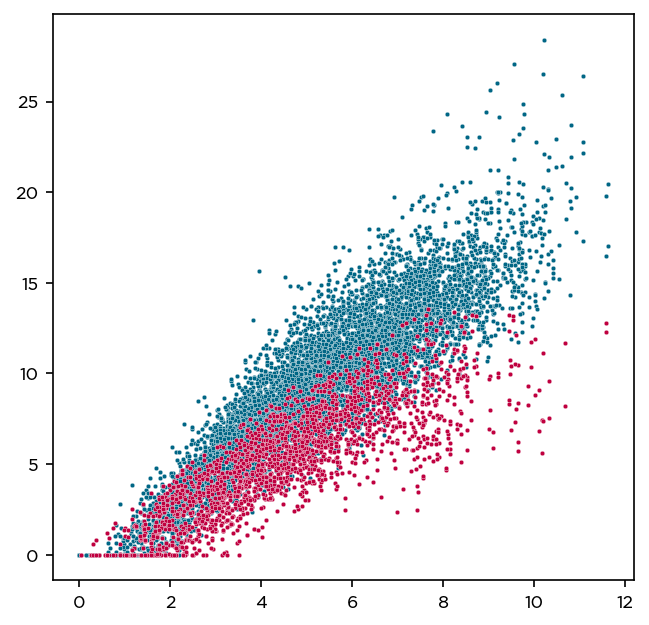

In [348]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_comm.flatten(),y=log_ci.flatten(),color=my_colors[0],s=5)
sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color=my_colors[-1],s=5)
#sns.lineplot(x=log_comm.flatten(), y=log_comm.flatten(), color='k', linestyle='--')


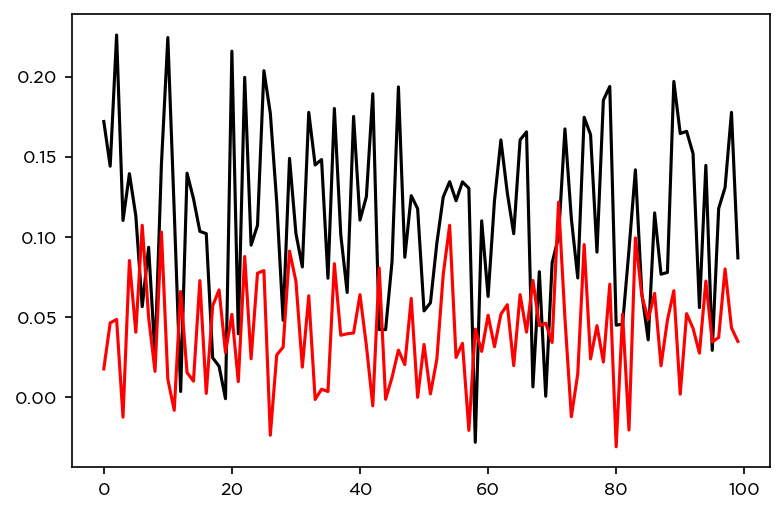

In [377]:
@njit
def wilson_cowan(x_e, x_i, W_ee, W_ei, W_ie, W_ii, theta_e, theta_i, tau_e, tau_i, dt, T):
    N = x_e.shape[0]
    ts = np.arange(0, T, dt)
    for t in ts:
        x_e_dot = -x_e/tau_e + np.tanh(W_ee @ x_e - W_ei @ x_i + theta_e)
        x_i_dot = -x_i/tau_i + np.tanh(W_ie @ x_e - W_ii @ x_i + theta_i)
        x_e += x_e_dot * dt
        x_i += x_i_dot * dt
    return x_e, x_i

# example parameters
N = 100
dt = 0.01
T = 100
theta_e = 0.3
theta_i = -0.7
tau_e = 2.0
tau_i = 1.0
W_ee = np.random.rand(N, N)*0.5
W_ei = np.random.rand(N, N)
W_ie = np.random.rand(N, N)
W_ii = np.random.rand(N, N)*0.5
# initial conditions
x_e = np.random.rand(N)
x_i = np.random.rand(N)
x_e_T, x_i_T = wilson_cowan(x_e, x_i, W_ee, W_ei, W_ie, W_ii, theta_e, theta_i, tau_e, tau_i, dt, T)

# plot the activity of the excitatory and inhibitory populations
plt.figure(dpi=150)
plt.plot(x_e_T,'k')
plt.plot(x_i_T,'r')

In [569]:
from networkx.algorithms.community import louvain_communities
def louvain_sort(df):
    G = nx.from_pandas_adjacency(df)
    partition = louvain_communities(G)
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    df['community'] = [partition[node_mapping.get(node, 0)] for node in G.nodes()]
    df.sort_values(by='community', inplace=True)
    return df

corrmat = pd.read_excel('/home/kayson/Downloads/data.xlsx',index_col=0)
corrmat = corrmat.T.fillna(0)
corrmat = corrmat + corrmat.T - np.diag(np.diag(corrmat))

np.fill_diagonal(corrmat.values, 0)
corrmat = corrmat[corrmat>0.05]
meh = louvain_sort(corrmat).fillna(0)
meh.drop(columns='community',inplace=True)


In [570]:
meh

correlation coefficients  hamed esmailion   dariush eghbali  esmaeil bakhshi  \
hamed esmailion                       0.00             0.21             0.28   
golshifteh farahani                   0.35             0.23             0.15   
saeed ghaseminejad                    0.70             0.16             0.18   
ali karimi                            0.36             0.25             0.21   
mahdieh golroo                        0.14             0.19             0.26   
kayson fakhar                         0.20             0.25             0.19   
narges mohammadi                      0.35             0.24             0.39   
masih alinejad                        0.39             0.25             0.28   
kaveh madani                          0.27             0.17             0.42   
mir hossein moosavi                   0.00             0.00             0.07   
firooz naderi                         0.19             0.16             0.27   
teachers representetive               0.22             0.12             0.35   
kurdish representetive                0.21             0.14             0.29   
mohammad noorizad                     0.24             0.22             0.33   
bahareh hedayat                       0.16             0.19             0.30   
abbas milani                          0.20             0.21             0.26   
mehdi yarrahi                         0.22             0.21             0.18   
molavi abdolhamid                     0.20             0.15             0.17   
toomaj salehi                         0.34             0.30             0.27   
dariush eghbali                       0.21             0.00             0.26   
esmaeil bakhshi                       0.28             0.26             0.00   
fariba balooch                        0.18             0.26             0.35   
nazanin boniadi                       0.46             0.24             0.25   
reza pahlavi                          0.22             0.19             0.15   
majid tavakoli                        0.25             0.20             0.37   
shirin ebadi                          0.29             0.21             0.27   
atena daemi                           0.31             0.24             0.44   
maryam rajavi                         0.10             0.10             0.12   
hossein ronaghi                       0.48             0.19             0.30   
fatemeh sepehri                       0.34             0.24             0.36   
nasrin sotoodeh                       0.37             0.23             0.42   
faraj sarkoohi                        0.17             0.18             0.31   
hassan shariatmadari                  0.18             0.20             0.29   
ali daei                              0.35             0.23             0.20   
others                                0.00             0.00             0.00   

correlation coefficients  fariba balooch   nazanin boniadi  reza pahlavi   \
hamed esmailion                      0.18             0.46           0.22   
golshifteh farahani                  0.17             0.28           0.15   
saeed ghaseminejad                   0.16             0.14           0.10   
ali karimi                           0.17             0.34           0.37   
mahdieh golroo                       0.32             0.15           0.09   
kayson fakhar                        0.17             0.25           0.16   
narges mohammadi                     0.31             0.26           0.19   
masih alinejad                       0.23             0.37           0.31   
kaveh madani                         0.24             0.21           0.11   
mir hossein moosavi                  0.00             0.00           0.00   
firooz naderi                        0.17             0.28           0.17   
teachers representetive              0.28             0.19           0.10   
kurdish representetive               0.26             0.19           0.09   
mohammad noorizad                    0.23

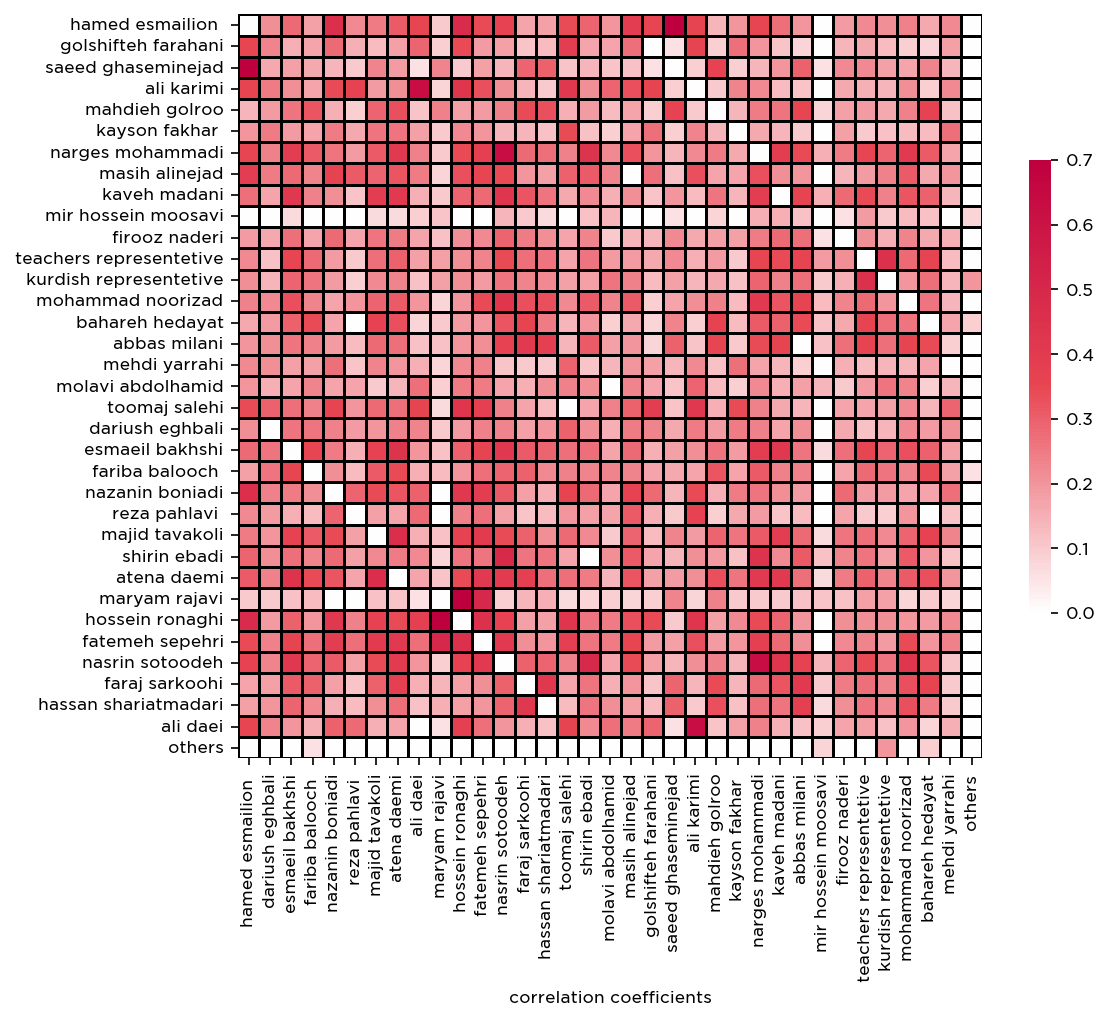

In [535]:
plt.figure(figsize=(8,8),dpi=150)
sns.heatmap(meh,center=0.,square=True,cmap=colormap,cbar_kws={"shrink": .5},linewidths=0.5, linecolor='k')
plt.savefig(f"coalitions.pdf",dpi=600,bbox_inches='tight')

In [599]:
corrmat = pd.read_excel('/home/kayson/Downloads/data.xlsx',index_col=0)
corrmat = corrmat.T.fillna(0)
corrmat = corrmat + corrmat.T - np.diag(np.diag(corrmat))

np.fill_diagonal(corrmat.values, 0)
corrmat = corrmat[corrmat>0.3]
corrmat.fillna(0,inplace=True)

G = nx.from_pandas_adjacency(corrmat)
partition = louvain_communities(G,1.5)
partition

[{'dariush eghbali'},
 {'ali daei',
  'ali karimi',
  'fatemeh sepehri',
  'golshifteh farahani',
  'hamed esmailion ',
  'hossein ronaghi',
  'kayson fakhar ',
  'maryam rajavi',
  'masih alinejad',
  'nazanin boniadi',
  'reza pahlavi ',
  'toomaj salehi'},
 {'molavi abdolhamid'},
 {'abbas milani',
  'atena daemi',
  'bahareh hedayat',
  'esmaeil bakhshi',
  'faraj sarkoohi',
  'fariba balooch ',
  'hassan shariatmadari',
  'kaveh madani',
  'kurdish representetive',
  'mahdieh golroo',
  'majid tavakoli',
  'mohammad noorizad',
  'narges mohammadi',
  'nasrin sotoodeh',
  'saeed ghaseminejad',
  'shirin ebadi',
  'teachers representetive'},
 {'mir hossein moosavi'},
 {'firooz naderi'},
 {'mehdi yarrahi'},
 {'others'}]

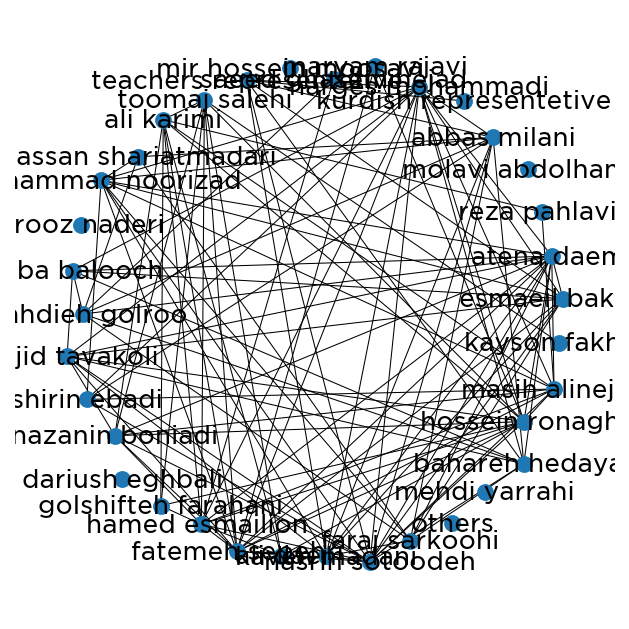

In [614]:
pos = nx.spring_layout(G,k=8,iterations=100)
plt.figure(figsize=(4,4),dpi=150)
nx.draw(G,pos=pos,node_size=50,edge_color='k',width=0.5,with_labels=True,)

In [565]:
corrmat

correlation coefficients  hamed esmailion   dariush eghbali  esmaeil bakhshi  \
hamed esmailion                        NaN             0.21             0.28   
dariush eghbali                       0.21              NaN             0.26   
esmaeil bakhshi                       0.28             0.26              NaN   
fariba balooch                         NaN             0.26             0.35   
nazanin boniadi                       0.46             0.24             0.25   
reza pahlavi                          0.22              NaN              NaN   
majid tavakoli                        0.25              NaN             0.37   
atena daemi                           0.31             0.24             0.44   
ali daei                              0.35             0.23              NaN   
maryam rajavi                          NaN              NaN              NaN   
hossein ronaghi                       0.48              NaN             0.30   
fatemeh sepehri                       0.34             0.24             0.36   
nasrin sotoodeh                       0.37             0.23             0.42   
faraj sarkoohi                         NaN              NaN             0.31   
hassan shariatmadari                   NaN              NaN             0.29   
toomaj salehi                         0.34             0.30             0.27   
shirin ebadi                          0.29             0.21             0.27   
molavi abdolhamid                      NaN              NaN              NaN   
masih alinejad                        0.39             0.25             0.28   
golshifteh farahani                   0.35             0.23              NaN   
saeed ghaseminejad                    0.70              NaN              NaN   
ali karimi                            0.36             0.25             0.21   
mahdieh golroo                         NaN              NaN             0.26   
kayson fakhar                          NaN             0.25              NaN   
narges mohammadi                      0.35             0.24             0.39   
kaveh madani                          0.27              NaN             0.42   
abbas milani                           NaN             0.21             0.26   
mir hossein moosavi                    NaN              NaN              NaN   
firooz naderi                          NaN              NaN             0.27   
teachers representetive               0.22              NaN             0.35   
kurdish representetive                0.21              NaN             0.29   
mohammad noorizad                     0.24             0.22             0.33   
bahareh hedayat                        NaN              NaN             0.30   
mehdi yarrahi                         0.22             0.21              NaN   
others                                 NaN              NaN              NaN   

correlation coefficients  fariba balooch   nazanin boniadi  reza pahlavi   \
hamed esmailion                       NaN             0.46           0.22   
dariush eghbali                      0.26             0.24            NaN   
esmaeil bakhshi                      0.35             0.25            NaN   
fariba balooch                        NaN             0.21            NaN   
nazanin boniadi                      0.21              NaN           0.29   
reza pahlavi                          NaN             0.29            NaN   
majid tavakoli                       0.31             0.34            NaN   
atena daemi                          0.34             0.32            NaN   
ali daei                              NaN             0.30           0.28   
maryam rajavi                         NaN              NaN            NaN   
hossein ronaghi                       NaN             0.42           0.24   
fatemeh sepehri                      0.27             0.39           0.27   
nasrin sotoodeh                      0.29             0.31            NaN   
faraj sarkoohi                       0.30

In [615]:
from netgraph import Graph

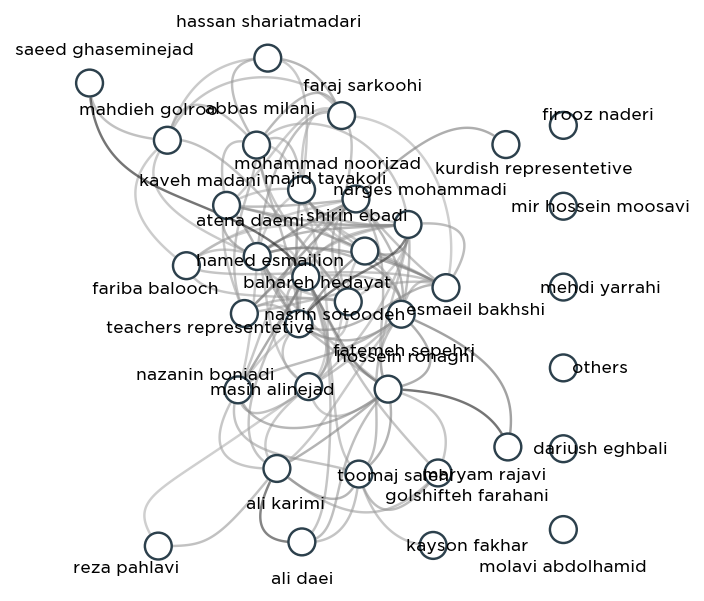

In [628]:
fig,axes = plt.subplot_mosaic([['A']],figsize=(5,5),dpi=150)

Graph(G,node_labels=True,node_label_offset=0.075,ax=axes['A'],edge_width=0.5,
      edge_alpha=0.6,edge_layout='curved')